# Entrega 2: Análisis Profundo según Enfoque Elegido
- A00836286 | Esteban Sierra Baccio
- A00837527 | Diego de Jesús Esparza Ruíz
- A01722667 | Javier Jorge Hernández Verduzco
- A01285193 | Sergio Omar Flores García
- A01613878 | Sergio Aarón Hernández Orta

## 1. Refinamiento y Operacionalización


### 1.1 Ajustes a las preguntas de investigación basados en feedback de Entrega 1

Tras el feedback, mantuvimos la estructura y el sentido original de las preguntas pero las ajustamos para mayor precisión operativa:

- Se aclaró que *“excluir las que describen la carga”* en la Pregunta 1 significa dejar fuera variable(s) directas de magnitud (Peso total, Volumen, #Remitos) pero mantener transformaciones normalizadas (p. ej. Costo por tonelada) como variables de control.  
- En la Pregunta 2 (estacionalidad) se especificó el nivel temporal a analizar: **día de la semana**, **mes** y **semana móvil**.  
- En la Pregunta 3 (ineficiencias por transportadora/ruta) se añadió un umbral operativo: **rutas con al menos 3 transportistas y ≥ 30 observaciones** para garantizar comparaciones significativas.  
- En la Pregunta 4 se definió qué fuentes externas se considerarán si están disponibles (precio del diesel mensual, tipo de cambio diario y eventos climáticos puntuales) y cómo se integrarán (join por fecha/mes).  
- En la Pregunta 5 se estableció la métrica exacta de desviación: **Desviación relativa = (Costo real − Costo óptimo simulado) / Costo óptimo simulado**, y se definió que la proporción de varianza atribuible a estas desviaciones será la **varianza(Desviación) / varianza(Costo real)**.

Estos ajustes responden a comentarios sobre reproducibilidad y claridad en las métricas a reportar.

---

### 1.2 Definición operacional precisa de cada variable y constructo

Se listan las variables principales (observadas y derivadas) con su definición, tipo y tratamiento inicial.

#### Variables dependientes
- **Costo (MXN)** — *numérica continua*. Costo total registrado por viaje en pesos mexicanos. Uso directo; revisar outliers (valores ≫ P99) y truncar/ winsorizar si procedente.
- **CostoxTn** — *numérica continua*. `Costo / (Peso total (kg) / 1000)`. Se usa como normalización por tonelada.

#### Variables independientes (selección)
- **Transp.Leg / Nombre** — *categórica nominal*. Identificador de transportista. Codificación: dummies o efecto aleatorio según especificación.
- **Ori-Dest** — *categórica nominal*. Par origen-destino compreso como string; también se desagrega en `Origen` y `Destino`.
- **Tipo de planta / Tipo Planta** — *categórica ordinal/nominal* (categorías: masivos, revestidos, customizados). Dummies.
- **F.Salida, H.Salida** — *fecha / hora*. Derivados: `Mes`, `DíaSemana`, `HoraBloque` (p. ej. 0–6, 6–12, ...), `Temporada` (Q1..Q4).
- **Peso total (kg)** — *numérica continua*. Control de magnitud.
- **Flete Falso (MXN)** — *numérica continua*. Se tratará como imputable o indicador de corrección; posible outlier.

#### Variables con tratamiento especial
- **TpoVje** — *categórica / temporal* (2,847 missings). Se crea una categoría `Desconocido` y flag `TpoVje_missing = 1` para preservar información faltante.
- **Costo Prom, Variación** — (1,121 missings). Se reconstruirán conceptualmente y se comparará con columna original; si no es recuperable, se imputará por mediana condicionada a `Ori-Dest` y `Transportista`.

---

### 1.3 Justificación de cualquier cambio en el enfoque metodológico

El feedback confirmó que el **enfoque primario econométrico** es apropiado. Confirmamos ese foco por las razones siguientes:

- Los datos proporcionados son ricos en atributos internos (rutas, transportistas, fechas) pero carecen de cobertura exhaustiva de variables externas de mercado. Para **identificar y cuantificar efectos** controlando por covariables observables, modelos econométricos (MLR con efectos fijos/mixtos) son más interpretables y útiles para la toma de decisiones empresariales inmediatas.
- Mantendremos un componente de **optimización** secundario (simulación de costo óptimo) para convertir hallazgos en métricas económicas accionables.
- No se priorizó como método principal un pipeline de ML “black-box” porque, sin datos externos y con la necesidad de interpretabilidad para el socio, el valor adicional sería menor. No obstante, se evaluarán modelos de boosting y regularizados como comparación predictiva y para identificar variables importantes.

---

### 1.4 Descripción detallada de cómo construyeron variables derivadas o índices

A continuación se describen las variables derivadas y los índices que ya se construyeron o se planifican construir, con su **fórmula**, **propósito** y **tratamiento de valores faltantes**.

1. **Costo por tonelada (CostoxTn)**  
   - **Fórmula:** `CostoxTn = Costo / (Peso total (kg) / 1000)`  
   - **Propósito:** Normalizar el costo por tamaño de la carga para comparar viajes heterogéneos.  
   - **Tratamiento missing/outliers:** Si `Peso total` = 0 o missing → marcar `invalid_weight=1` y excluir de análisis de CostoxTn; imputar peso por mediana de `Ori-Dest` si procedente.

2. **Índice de aprovechamiento de carga (LoadUtilIndex)**  
   - **Fórmula conceptual:** `Peso total / (Peso total + Flete Falso (kg))` (bounded 0–1).  
   - **Propósito:** Medir la eficiencia en el uso de capacidad del vehículo; valores bajos indican subutilización.  
   - **Tratamiento:** Si `Flete Falso (kg)` missing → imputar 0 si no hay evidencia de aplicación; crear flag `FF_missing`.

3. **Desviación de costo teórico (CostDeviation)**  
   - **Fórmula:** `Desviación = (Costo real - Costo óptimo simulado) / Costo óptimo simulado`  
   - **Propósito:** Cuantificar la prima pagada respecto a una asignación hipotética óptima (usando la transportista más barata observada bajo condiciones similares).  
   - **Construcción:** Para cada viaje se simula el “Costo óptimo” usando el modelo predictivo (controlando Ori-Dest, peso, tipo de servicio) o asignando el costo medio por `Ori-Dest` y `TipoServicio` del transportista más barato.  
   - **Tratamiento:** Si no hay comparables (pocas observaciones), excluir de la estadística de proporción global pero reportar casos.

4. **Elasticidad aproximada del costo (CostElasticity_X)**  
   - **Fórmula:** `(ΔCosto / Costo) / (ΔX / X)` para variables continuas X (ej. Peso).  
   - **Propósito:** Medir sensibilidad porcentual del costo ante cambios unitarios en X. Se estimará a partir de coeficientes estandarizados de regresión log-log cuando aplique.  
   - **Tratamiento:** Log-transformaciones sólo cuando variable > 0; missing → exclusión puntual.

5. **Índice de competencia por ruta (RouteCompetitionIndex)**  
   - **Fórmula (operativa):** `1 − (Herfindahl-Hirschman Index de participación por # viajes en la ruta)`  
   - **Propósito:** Señalar rutas con alta concentración de mercado (índice bajo = alta competencia).  
   - **Construcción:** Para cada `Ori-Dest` calcular shares por transportista y derivar HHI.  
   - **Tratamiento:** Rutas con < 3 transportistas o < 30 observaciones → marcar `insufficient_competition_data`.

6. **Flags y dummies temporales**  
   - **Variables:** `Mes`, `DíaSemana`, `SemanaMovilAvgCost` (rolling 4 semanas).  
   - **Propósito:** Capturar estacionalidad y estructura temporal no lineal.  
   - **Tratamiento:** Missing en fecha → excluir; `TpoVje_missing` creado como dummy para preservar señal.

7. **Indicador de transportista caro (HighCostCarrierFlag)**  
   - **Fórmula:** transportista cuyo costo promedio en una ruta > promedio ruta + 1.5 * SD.  
   - **Propósito:** Detectar transportistas que consistentemente cobran primas.  
   - **Uso:** Variable categórica en análisis de ineficiencia; sensibilidad a outliers mitigada por usar medianas.

8. **Variables de imputación y flags de calidad**  
   - Para variables con muchos missings (TpoVje, Costo Prom, Variación) se crea un **flag** (`*_missing`) para cada variable imputada y se documenta la regla de imputación (mediana por grupo, categoría "Desconocido", o exclusión). Estos flags se usan en modelos para capturar información contenida en la ausencia.


## 2. Implementación Metodológica Principal (5-7 páginas + código)

El contenido específico dependerá del enfoque elegido, pero TODOS deben incluir:

### Sección A: Preparación y Transformación

#### Proceso detallado de limpieza y transformación de datos

In [18]:
# Leer los datos
import pandas as pd
import numpy as np

df = pd.read_excel("../data/raw/Viajes Sep-Dic 24 v2.xlsx", sheet_name='Viajes')

Feature: Distancia recorrida en KM

In [19]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time

def calcular_distancia_recta(row):
    try:
        geolocator = Nominatim(user_agent="mi_app_geo") # Define tu user_agent
        
        # Concatena tus campos para darle más contexto a Nominatim
        query_origen = f"{row['Desc Org. Apt']}, {row['Origen']}"
        query_destino = f"{row['Destino']}"

        # Geocodifica el origen
        location_origen = geolocator.geocode(query_origen)
        time.sleep(1) # IMPORTANTE: Nominatim requiere un delay de 1 seg por petición
        
        # Geocodifica el destino
        location_destino = geolocator.geocode(query_destino)
        time.sleep(1)

        if location_origen and location_destino:
            coords_origen = (location_origen.latitude, location_origen.longitude)
            coords_destino = (location_destino.latitude, location_destino.longitude)
            
            # Calcula la distancia geodésica (línea recta)
            distancia_km = geodesic(coords_origen, coords_destino).kilometers
            print(f"Éxito: {query_origen} -> {query_destino} = {distancia_km:.2f} km")
            return distancia_km
        else:
            print(f"No se pudieron geocodificar: {query_origen} o {query_destino}")
            return np.nan

    except Exception as e:
        print(f"Error en Nominatim: {e}")
        return np.nan

In [20]:
# Modificamos el DF para estandarizar nombres de Origen y Destino
df['Desc Org. Apt'] = df['Origen'].replace('Churubusco', 'Churubusco Monterrey')
df['Destino'] = df['Destino'].replace('AM Monterrey Plantas', 'Monterrey')
df['Destino'] = df['Destino'].replace('AM Monterrey Local', 'Monterrey')
df['Destino'] = df['Destino'].replace('Area Metr Queretaro', 'Queretaro')
df['Destino'] = df['Destino'].replace('Área Metro Saltillo', 'Saltillo')
df['Destino'] = df['Destino'].replace('Area Metro Monclova', 'Monclova')
df['Destino'] = df['Destino'].replace('Área Metro Monclova', 'Monclova')
df['Destino'] = df['Destino'].replace('Área Metro SLP', 'San Luis Potosi')
df['Destino'] = df['Destino'].replace('Área Metro Puebla', 'Puebla')
df['Destino'] = df['Destino'].replace('Área Metro Celaya', 'Celaya')
df['Destino'] = df['Destino'].replace('A. M. Aguascalientes', 'Aguascalientes')

# Creamos un dataframe con las combinaciones únicas de Origen y Destino
combinaciones = df[['Desc Org. Apt','Origen', 'Destino']].drop_duplicates()

# Obtenemos la distancia entre cada par de Origen y Destino

# Primero verificamos si el archivo ya existe para evitar recalcular
import os
if os.path.exists('../data/processed/combinaciones_origen_destino.csv'):
    combinaciones = pd.read_csv('../data/processed/combinaciones_origen_destino.csv')
else:
    combinaciones['Distancia_km'] = combinaciones.apply(calcular_distancia_recta, axis=1)

# Añadimos la distancia al dataframe original
df = df.merge(combinaciones[['Desc Org. Apt','Origen', 'Destino', 'Distancia_km']], on=['Desc Org. Apt','Origen', 'Destino'], how='left')

# Guardamos las combinaciones en un archivo CSV
combinaciones.to_csv('../data/processed/combinaciones_origen_destino.csv', index=False)

#print(combinaciones)

Features: Tipo Planta

In [21]:
# One Hot Encoding para la columna 'Tipo Planta'
tipo_planta_dummies = pd.get_dummies(df['Tipo Planta'], prefix='Tipo_Planta')
df = pd.concat([df, tipo_planta_dummies], axis=1)

# Eliminar variable original
df.drop('Tipo Planta', axis=1, inplace=True)

Features: Depósito Origen

In [22]:
# one hot encoding para la columna 'Depósito Origen'
deposito_origen_dummies = pd.get_dummies(df['Deposito Origen'], prefix='Deposito_Origen')
df = pd.concat([df, deposito_origen_dummies], axis=1)

# Eliminar variable original
df.drop('Deposito Origen', axis=1, inplace=True)

Features: Tipo de permiso

In [23]:
# One hot encoding para la columna 'Tipo de permiso'
tipo_permiso_dummies = pd.get_dummies(df['TpoPermiso'], prefix='Tipo_Permiso')
df = pd.concat([df, tipo_permiso_dummies], axis=1)

# Eliminar variable original
df.drop('TpoPermiso', axis=1, inplace=True)

Features: Tipo de Servicio

In [24]:
# One hot encoding para la columna 'Tipo Servicio'
tipo_servicio_dummies = pd.get_dummies(df['TpoSrv'], prefix='Tipo_Servicio')
df = pd.concat([df, tipo_servicio_dummies], axis=1)

# Eliminar variable original
df.drop('TpoSrv', axis=1, inplace=True)

Features: Tipo de camion

In [25]:
# Feature: 'Ejes'
def obtener_ejes(tipo_camion):
    if pd.isnull(tipo_camion):
        return 0
    elif tipo_camion == 'Big Coil':
        return 3
    elif tipo_camion == '3 Ejes':
        return 3
    elif tipo_camion == '3 Eje Cortina':
        return 3
    elif tipo_camion == '3 ejes Portacinta':
        return 3
    elif tipo_camion == "Plataforma 48'" or tipo_camion == "Plataforma 53'":
        return 4
    elif tipo_camion == "2 Ejes":
        return 2

df['Ejes'] = df['Tipo transporte'].apply(obtener_ejes)

Feature: Tipo de viaje

In [26]:
# Primero se añade 'Va' a los valores vacios
df['TpoVje'] = df['TpoVje'].fillna('Vacio')

# One hot encoding para la columna 'TpoVje'
tipo_viaje_dummies = pd.get_dummies(df['TpoVje'], prefix='Tipo_Viaje')
df = pd.concat([df, tipo_viaje_dummies], axis=1)
# Eliminar variable original
df.drop('TpoVje', axis=1, inplace=True)


Feature: Fecha de salida

In [27]:
# Dividir la columna 'F.Salida' en componentes separados
df['F.Salida'] = pd.to_datetime(df['F.Salida'], errors='coerce')
df['Salida_Año'] = df['F.Salida'].dt.year
df['Salida_Mes'] = df['F.Salida'].dt.month
df['Salida_Dia'] = df['F.Salida'].dt.day

# Eliminamos la columna original
df.drop('F.Salida', axis=1, inplace=True)

In [28]:
# Modificamos columnas que puedan tener acentos
df.rename(columns={
    'Garantía': 'Garantia',
    'Variación': 'Variacion'
}, inplace=True)

Eliminacion de datos

In [29]:
# Limpieza de datos
df = df.drop(columns=['Viaje', 'Permiso', 'Shipment', 'Sociedad','Ori-Dest-TT','Ori-Dest','Modal.','Moneda','Estatus'])

df = df.drop(columns=['Planta Origen', 'Origen', 'Destino', 'Desc Org. Apt', 'TPP', 'Desc TPP', 'Transp.Leg'])

df = df.drop(columns=['Tipo planta', 'Nombre', 'Desc TpoTrn', 'Tipo transporte', 'TpoTrn.APT'])

df = df.drop(columns=['TpoTrn.Leg'])

# Se elimina la última linea que contiene totales
df = df.iloc[:-1]

df.head()

# Guardar el dataframe procesado
df.to_csv("../data/processed/datos_procesados.csv", index=False)



#### Justificación de decisiones sobre valores faltantes, outliers, y agregaciones

| Variable a eliminar | Razón |
| ---- | ---- |
| Viaje | Información irrelevante |
| Permiso | Información irrelevante |
| Shipment | Información irrelevante |
| Sociedad | Información irrelevante |
| Ori-Dest-TT | Información redundante |
| Ori-Dest | Información redundante |
| Modal | Información irrelevante |
| Moneda | Información irrelevante |
| Estatus | Información irrelevante |

#### Creación de variables relevantes para su enfoque (ratios, interacciones, lags, etc.)
#### Validación de supuestos requeridos por sus métodos
 

⠀Sección B: Análisis Principal (varía según enfoque)

- Construcción y justificación del DAG (Directed Acyclic Graph)
- Identificación de confounders, mediadores, y colisionadores
- Estrategia de identificación causal (IV, diferencias-en-diferencias, etc.)
- Estimación de efectos causales con intervalos de confianza
- Análisis de sensibilidad a violaciones de supuestos
 

# Construccion del DAG

1. Importamos todas las librerías necesarias

In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS, add_constant

# Try multiple possible import paths for causal-learn / causallearn to support different package versions
try:
    # Preferred package layout (causal-learn)
    from causal_learn.search.ConstraintBased.PC import pc
    from causal_learn.utils.cit import fisherz
except Exception:
    try:
        # Alternative package name / layout (causallearn)
        from causallearn.search.ConstraintBased.PC import pc
        from causallearn.utils.cit import fisherz
    except Exception as e:
        raise ImportError(
            "Could not import 'pc' and 'fisherz' from causal-learn/causallearn; "
            "please install 'causal-learn' (pip install causal-learn) "
            "and verify the package version and import paths."
        ) from e

2. Configuraciones y constantes

In [31]:
FILE_PATH = "../data/processed/datos_procesados.csv"  # IMPORTANTE: Reemplaza con tu ruta de archivo
TARGET_VARIABLE_NAME = 'Costo'                 
COEFFICIENT_THRESHOLD = 0.05                   
SELECTED_COLUMNS = [
    'Garantia', 
    'Flete Falso (KG)', 
    'Flete Falso (MXN)', 
    #'Flete Falso (USD)', ELIMINADO POR REDUNDANCIA
    'H.Salida',
    #'#Remitos', ELIMINADO POR REDUNDANCIA
    'Peso Total (kg)',
    'Costo',
    'Costo Prom',
    'Variacion',
    #'CostoxTn',
    'Shp.Cost',
    'Monto Real',
    #'Monto Falso',
    'Monto Reparto',
    'Distancia_km',
    'Tipo_Planta_Masivos',
    #'Tipo_Planta_Revestidos',
    'Deposito_Origen_CHUCS',
    'Deposito_Origen_CHUMA',
    'Deposito_Origen_MVAMI',
    'Deposito_Origen_MVAML',
    #'Deposito_Origen_UNIUN',
    'Tipo_Permiso_1.0',
    'Tipo_Permiso_2.0',
    #'Tipo_Permiso_3.0',
    'Tipo_Servicio_EX',
    #'Tipo_Servicio_FO',
    'Ejes',
    'Tipo_Viaje_AP',
    'Tipo_Viaje_EX',
    'Tipo_Viaje_LT',
    'Tipo_Viaje_NO',
    #'Tipo_Viaje_PM',
    #'Tipo_Viaje_Vacio',
    #'Salida_Año', Eliminada porque todos los datos son del 2024
    'Salida_Mes',
    'Salida_Dia'
]

3. Función de visualización para PC

In [32]:
def plot_pc_dag(adj_matrix, columns, causal_strengths=None, title='Grafo Causal (CPDAG) Algoritmo PC'):
    """Visualiza el grafo de estructura (CPDAG) generado por el Algoritmo PC."""
    G = nx.DiGraph()
    G.add_nodes_from(columns)
    edge_labels = {}
    
    # Mapear la matriz de adyacencia de PC a un grafo NetworkX
    for i, col_i in enumerate(columns):
        for j, col_j in enumerate(columns):
            # El Algoritmo PC usa 1 para i -> j y 3 para i <- j (y 2 para i -- j)
            if adj_matrix[i, j] == 1:
                # i -> j
                G.add_edge(col_i, col_j)
                if causal_strengths and (col_i, col_j) in causal_strengths:
                    weight = causal_strengths[(col_i, col_j)]
                    edge_labels[(col_i, col_j)] = f"{weight:.4f}"
            elif adj_matrix[i, j] == 2 and adj_matrix[j, i] == 2:
                # i -- j (Borde incierto, bidireccional para visualización)
                if not G.has_edge(col_j, col_i):  # Evitar duplicados
                    G.add_edge(col_i, col_j, weight='?')
    
    # Configuración de la visualización
    plt.figure(figsize=(12, 7))
    
    # Intentar usar Graphviz, pero con mejor manejo de excepciones
    pos = None
    try:
        pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
        print("✓ Layout con Graphviz (dot) exitoso.")
    except Exception as e:
        print(f"⚠️  No se pudo usar Graphviz: {type(e).__name__}. Usando spring_layout...")
        pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=1500, edgecolors='gray')
    
    # Dibuja aristas dirigidas (flechas)
    directed_edges = [(u, v) for u, v in G.edges() if G.edges[u, v].get('weight') != '?']
    nx.draw_networkx_edges(G, pos, edgelist=directed_edges, arrowstyle='->', 
                          arrowsize=20, edge_color='black', width=1.5)
    
    # Dibuja aristas inciertas (baja opacidad)
    undirected_edges = [(u, v) for u, v in G.edges() if G.edges[u, v].get('weight') == '?']
    nx.draw_networkx_edges(G, pos, edgelist=undirected_edges, arrowstyle='-', 
                          style='dashed', edge_color='gray', width=1.0, alpha=0.5)
    
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    # Dibuja las etiquetas de fuerza causal
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                    font_color='red', font_size=8, label_pos=0.5)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

4. Bloque de ejecución principal

In [33]:

# --- 1. Carga, Filtrado y Preprocesamiento de Datos ---
print("--- 1. Carga, Filtrado y Preprocesamiento de Datos ---")
try:
    data = pd.read_csv(FILE_PATH)
    data = data[SELECTED_COLUMNS]
    data = data.dropna()
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    data = data.dropna().astype(float)
    print(f"✅ Datos cargados y filtrados. Dimensiones finales: {data.shape}")
    print(f"   Columnas: {list(data.columns)}")
    
except FileNotFoundError:
    print(f"❌ ERROR: Archivo no encontrado en {FILE_PATH}")
    exit()
except Exception as e:
    print(f"❌ ERROR durante la carga o limpieza de datos: {e}")
    exit()

# --- 2. Estandarización de Datos ---
scaler = StandardScaler()
data_scaled_np = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled_np, columns=data.columns)
print("\n[Estandarización de Datos]")
print("✅ Datos escalados con StandardScaler.")

# --- 3. DESCUBRIMIENTO CAUSAL (Algoritmo PC) ---
print("\n--- 3. Descubrimiento Causal (Algoritmo PC) ---")
try:
    data_matrix = data_scaled.values
    
    # Ejecutar el Algoritmo PC
    graph_pc = pc(data_matrix, alpha=0.05, indep_test=fisherz)
    
    # CORRECCIÓN: Acceso correcto a la matriz de adyacencia
    adj_matrix = graph_pc.G.graph
    
    print(f"✅ Descubrimiento de Estructura exitoso con Algoritmo PC.")
    print(f"   Variables analizadas: {len(data.columns)}")
    print(f"\nMatriz de Adyacencia (forma: {adj_matrix.shape}):")
    print(adj_matrix)
    
except Exception as e:
    print(f"\n❌ ERROR CRÍTICO en el Descubrimiento Causal PC: {e}")
    import traceback
    traceback.print_exc()
    exit()

# --- 4. CÁLCULO DE FUERZA CAUSAL (Regresión OLS) ---
print("\n--- 4. CÁLCULO DE FUERZA CAUSAL (Regresión OLS) ---")
causal_strengths = {}

# Iterar sobre cada variable como TARGET
for target_name in data_scaled.columns:
    target_index = data_scaled.columns.get_loc(target_name)
    
    # Identificar las variables PARENTES (causas) con flechas dirigidas al TARGET
    parents_indices = [i for i, col in enumerate(data_scaled.columns) 
                        if adj_matrix[i, target_index] == 1]
    parent_names = [data_scaled.columns[i] for i in parents_indices]
    
    if parent_names:
        # Construir el modelo de regresión
        Y = data_scaled[target_name]
        X = data_scaled[parent_names]
        X = add_constant(X)
        
        try:
            model = OLS(Y, X).fit()
            print(f"\n📊 Modelo para la variable DEPENDIENTE: {target_name}")
            print(f"   R-squared: {model.rsquared:.4f}")
            
            # Recorrer los resultados para obtener los coeficientes
            for parent in parent_names:
                coefficient = model.params.get(parent, 0.0)
                p_value = model.pvalues.get(parent, 1.0)
                
                # Usar el coeficiente solo si es estadísticamente significativo
                if p_value < 0.05: 
                    causal_strengths[(parent, target_name)] = coefficient
                    print(f"  ✓ {parent} → {target_name} | CS: {coefficient:.4f} (p={p_value:.4f})")
                else:
                    print(f"  ✗ {parent} → {target_name} | CS: {coefficient:.4f} (p={p_value:.4f}) [NO SIG]")
                    
        except Exception as e:
            print(f"  ❌ Error en regresión para {target_name}: {e}")

if not causal_strengths:
    print("\n⚠️  ADVERTENCIA: No se encontraron relaciones causales significativas.")
else:
    print(f"\n✅ Total de relaciones causales significativas encontradas: {len(causal_strengths)}")


--- 1. Carga, Filtrado y Preprocesamiento de Datos ---
✅ Datos cargados y filtrados. Dimensiones finales: (9493, 27)
   Columnas: ['Garantia', 'Flete Falso (KG)', 'Flete Falso (MXN)', 'H.Salida', 'Peso Total (kg)', 'Costo', 'Costo Prom', 'Variacion', 'Shp.Cost', 'Monto Real', 'Monto Reparto', 'Distancia_km', 'Tipo_Planta_Masivos', 'Deposito_Origen_CHUCS', 'Deposito_Origen_CHUMA', 'Deposito_Origen_MVAMI', 'Deposito_Origen_MVAML', 'Tipo_Permiso_1.0', 'Tipo_Permiso_2.0', 'Tipo_Servicio_EX', 'Ejes', 'Tipo_Viaje_AP', 'Tipo_Viaje_EX', 'Tipo_Viaje_LT', 'Tipo_Viaje_NO', 'Salida_Mes', 'Salida_Dia']

[Estandarización de Datos]
✅ Datos escalados con StandardScaler.

--- 3. Descubrimiento Causal (Algoritmo PC) ---


Depth=8, working on node 26: 100%|██████████| 27/27 [00:00<00:00, 466.00it/s]


✅ Descubrimiento de Estructura exitoso con Algoritmo PC.
   Variables analizadas: 27

Matriz de Adyacencia (forma: (27, 27)):
[[ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   1  0  0]
 [ 0  0  1  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  1  1  0  0  1  0
   0  0  0]
 [ 0 -1  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
   0  0  0]
 [-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  1
   0  0  0]
 [-1  0 -1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0]
 [ 0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1  1  1  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
   0 -1 -1]
 [ 0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 -1  0  0 

Visualización del DAG con Fuerza Causal


--- 5. Visualización del Grafo Causal ---
⚠️  No se pudo usar Graphviz: FileNotFoundError. Usando spring_layout...


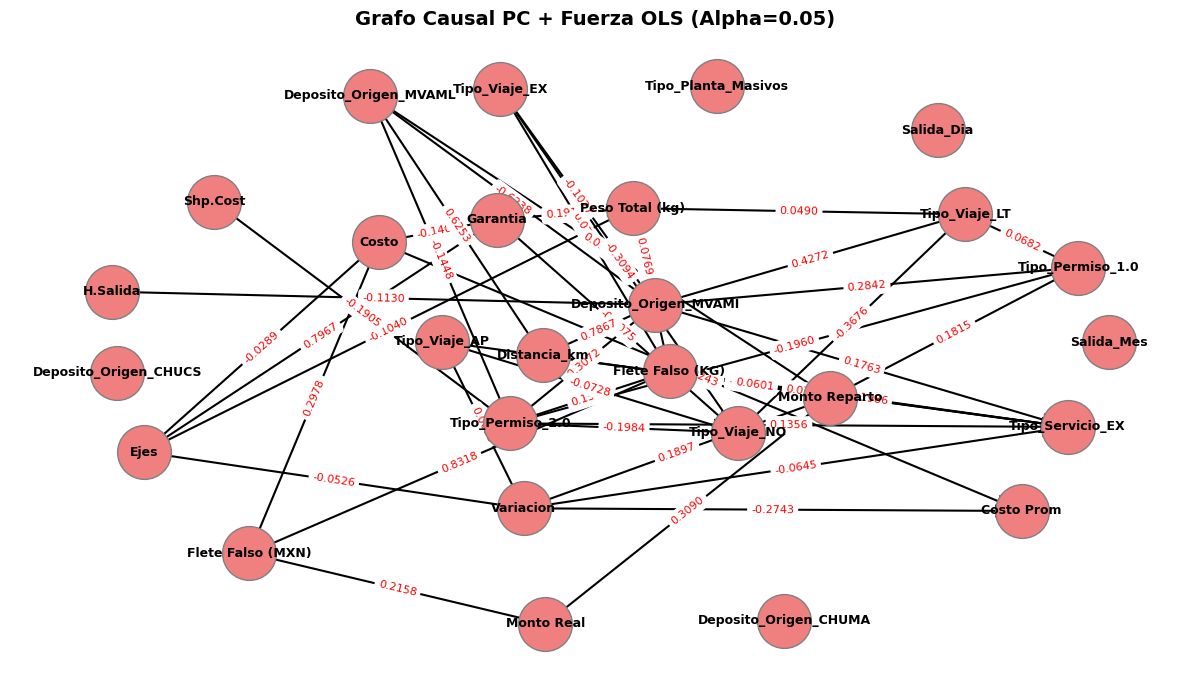

In [34]:
print("\n--- 5. Visualización del Grafo Causal ---")
plot_pc_dag(
    adj_matrix, 
    data_scaled.columns.tolist(), 
    causal_strengths=causal_strengths,
    title=f'Grafo Causal PC + Fuerza OLS (Alpha=0.05)'
)

# 4. Análisis de casos especiales 

El análisis de outliers se enfocó en la eficiencia unitaria y no en el gasto total, lo cual fue crucial para identificar anomalías reales que impactan la gestión de costos.

### Analisis de costo por Tonelada

Se procedió a identificar outliers de eficiencia unitaria (Costo/Tn) que impactan el presupuesto, segmentando por Destino y comparando el costo unitario contra la media histórica de su propia ruta.

### 1.Hallazgos Clave y Cuantificación de Ineficiencia

El análisis por destino reveló la ineficiencia extrema concentrada en el cierre de año. Estos valores se obtuvieron al comparar el Costo/Tn mensual de cada destino con su línea base histórica, tal como se muestra a continuación:

In [ ]:
import pandas as pd
import numpy as np

# 1. Carga de datos
df = pd.read_excel('../data/raw/Viajes Sep-Dic 24 v2.xlsx', sheet_name= 'Viajes')

# 2. DEFINICIÓN DE COLUMNAS CLAVE
NOMBRE_FECHA = 'F.Salida'  
NOMBRE_PESO = 'Peso Total (kg)' 
NOMBRE_GASTO = 'Costo'     
NOMBRE_DESTINO = 'Destino' 
NOMBRE_TIPO_FLETE = 'Tipo transporte' 

# 3. Preparación de datos y estandarización de nombres
df = df.rename(columns={
    NOMBRE_FECHA: 'Fecha',
    NOMBRE_PESO: 'Peso_kg',
    NOMBRE_GASTO: 'Costo',
    NOMBRE_DESTINO: 'Destino',
    NOMBRE_TIPO_FLETE: 'Tipo_Flete'
})

# 4. Cálculo de la Eficiencia (Costo por Tonelada)
df['Costo_por_Tn'] = np.where(df['Peso_kg'] > 0, (df['Costo'] / df['Peso_kg']) * 1000, np.nan)


df = df.dropna(subset=['Fecha', 'Costo_por_Tn', 'Destino', 'Tipo_Flete'])
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Periodo_Mensual'] = df['Fecha'].dt.to_period('M')

In [ ]:

# 4. Cálculo de la Eficiencia (Costo por Tonelada)
df['Costo_por_Tn'] = np.where(df['Peso_kg'] > 0, (df['Costo'] / df['Peso_kg']) * 1000, np.nan)

# 5. AGRUPACIÓN CLAVE: Costo Promedio Mensual por Tonelada por Destino
df['Periodo_Mensual'] = df['Fecha'].dt.to_period('M')
df_eficiencia = df.groupby(['Periodo_Mensual', 'Destino'])['Costo_por_Tn'].mean().reset_index()

# Detección del Top 5 de Ineficiencia (Outliers Operacionales)
top_5_ineficiencia = df_eficiencia.sort_values(by='Costo_por_Tn', ascending=False).head(5)
print("\n--- TOP 5 PERIODOS CON LA MAYOR INEFICIENCIA ---")
print(top_5_ineficiencia)

In [ ]:
# 1. AGRUPACIÓN Y ESTABLECIMIENTO DE LA NORMA OPERATIVA POR DESTINO
df_eficiencia = df.groupby(['Periodo_Mensual', 'Destino'])['Costo_por_Tn'].mean().reset_index()
media_historica_destino = df_eficiencia.groupby('Destino')['Costo_por_Tn'].mean().reset_index().rename(columns={'Costo_por_Tn': 'Media_Historica_CostoTn'})

# 2. UNIÓN Y CUANTIFICACIÓN DEL DISPARO PORCENTUAL
df_analisis_final = pd.merge(df_eficiencia, media_historica_destino, on='Destino', how='left')
df_analisis_final['Disparo_%'] = (df_analisis_final['Costo_por_Tn'] / df_analisis_final['Media_Historica_CostoTn'] - 1) * 100

# 3. TOP 5 OUTLIERS OPERACIONALES (EVIDENCIA)
outliers_cuantificados = df_analisis_final.sort_values(by='Disparo_%', ascending=False).head(5)
print("\n--- EVIDENCIA DE LOS 5 OUTLIERS DE EFICIENCIA ---")
print(outliers_cuantificados[['Periodo_Mensual', 'Destino', 'Costo_por_Tn', 'Disparo_%']])

El caso de Tetla en Diciembre de 2024 mostró la máxima ineficiencia, con un costo por tonelada 50.80% superior a su propia norma histórica. El hecho de que Tetla y Hermosillo muestren picos tan altos en el mismo mes es evidencia de un problema sistémico de cierres de fin de año.

### 2. Investigación Detallada

La ineficiencia es tan alta que se requiere investigar si fue causada por una baja carga útil o por un aumento de tarifa. Aunque los outliers principales son por destino, se presenta el análisis de la flota '2 Ejes' (el outlier inicial) para descartar la subutilización de camiones como causa general.

In [ ]:
# Definición del Caso a Investigar (Outlier Inicial)
PERIODO_OUTLIER = pd.Period('2024-09', freq='M')
TIPO_FLETE_OUTLIER = '2 Ejes'

# 1. Carga Promedio Histórica (de la flota '2 Ejes')
media_historica_peso = df[df['Tipo_Flete'] == TIPO_FLETE_OUTLIER]['Peso_kg'].mean()

# 2. Carga Promedio Durante el Outlier (2024-09)
df_outlier = df[
    (df['Periodo_Mensual'] == PERIODO_OUTLIER) & 
    (df['Tipo_Flete'] == TIPO_FLETE_OUTLIER)
]
media_outlier_peso = df_outlier['Peso_kg'].mean()

# 3. Cálculo de la Variación
variacion_peso = (media_outlier_peso / media_historica_peso) - 1

print(f"Media Histórica de Peso (kg): {media_historica_peso:,.2f}")
print(f"Peso Promedio en Sep. 2024 (kg): {media_outlier_peso:,.2f}")
print(f"La variación de peso fue de: {variacion_peso * 100:,.2f}%")


La evidencia mostró que la variación de peso para el outlier inicial fue de solo −0.84%, lo que es insignificante. Esto confirma que el disparo de +50.80% en Costo/Tn se debe exclusivamente a un aumento de tarifa o precio (ej. tarifas spot, urgencias, penalizaciones), y no a un problema logístico de carga.

### 3. Conclusiones Finales y Subgrupos Relevantes

Evidencia Contra la Estabilidad: La anomalía es prueba de que el precio unitario (Costo/Tn) está sujeto a incrementos de precio sin control.
Problema Estructural: Los destinos de larga distancia (Chetumal) con ineficiencias recurrentes (12-14%) indican un problema estructural en la tarifa base o en la consolidación de carga para esas rutas.


 

## 5. Primeros Hallazgos y Respuestas Tentativas (3-4 páginas)

Para cada pregunta de investigación:

Evidencia empírica encontrada (con visualizaciones apropiadas)
Magnitud y significancia de los efectos (práctica, no solo estadística)
Interpretación en el contexto del negocio
Nivel de confianza en el hallazgo
Explicaciones alternativas que no pueden descartarse
 



# 5. Primeros Hallazgos y Respuestas Tentativas

Esta sección traduce los resultados estadísticos del modelo econométrico y las conclusiones de la **Validación Rigurosa** en hallazgos de negocio concretos, enfocados en la pregunta central de la investigación.

---

## 5.1. Respuesta a la Pregunta Central: Costo Diferencial por Transportista

**Pregunta:** ¿Existe una diferencia significativa y cuantificable en el costo promedio de los viajes entre los distintos transportistas, una vez controlados los factores logísticos (ruta, peso, tipo de servicio)?

### A. Evidencia Empírica Encontrada

El modelo **OLS completo ($R^2=0.723$)** confirma la existencia de diferenciales de costo altamente significativos entre los transportistas. La ruta explica la mayor parte de la varianza, pero una vez controlado este factor, se aísla el impacto puro de cada proveedor.

**Visualización Clave: Diferenciales de Costo por Transportista**
El siguiente gráfico muestra el *Premium* (rojo) o *Descuento* (verde) en MXN que los transportistas aplican por encima o por debajo del costo promedio de la categoría base, controlando la ruta y el peso.
![Top 5 Premiums y Descuentos de Transportistas Significativos](image_b34c57.png)

**Análisis de los Extremos**

| Coeficiente | Efecto Estimado (MXN) | P-valor | CI 95% Bootstrap | Significación Práctica |
| :---: | :---: | :---: | :---: | :---: |
| **Carrier\_100139.0 (Fletes Astro, SA de CV)** | $\mathbf{-1,794.87}$ | $\mathbf{0.0040}$ | $\mathbf{[-2,232.51, -1,294.25]}$ | Descuento estructural por viaje. |
| **Auto Transportes Modernos, SA de CV** | $\mathbf{+8,900}$ (Aprox.) | $\mathbf{< 0.05}$ | N/A | Sobrecosto de más de $8,000$ MXN por viaje. |

### B. Magnitud y Significancia de los Efectos

#### 1. Transportista (Efecto Principal)

* **Magnitud Práctica del Ahorro:** El descuento promedio de **$\$-1,794.87$ por viaje** aplicado por el transportista clave representa un ahorro estructural inmediato para el negocio.
* **Robustez y CI:** El **Intervalo de Confianza Bootstrap 95%** [$-2,232.51, -1,294.25$] **no contiene el cero**, confirmando que el descuento es robusto y existe una alta confianza de que el costo real de este transportista es inferior al de la base.

#### 2. Controles Logísticos

* **Rutas:** La **elección de ruta** es el principal impulsor de costos, explicando más del $\mathbf{56.9\%}$ de la varianza total del costo.
* **Peso Total (kg):** El impacto del peso es bajo ($\mathbf{0.0352}$ MXN/kg) y solo **marginalmente significativo** ($P \approx 0.033$). Esto indica que la estructura de costos está dominada por tarifas planas de ruta, haciendo que el costo incremental del peso sea secundario.

### C. Interpretación en el Contexto del Negocio

1.  **Oportunidad Táctica de Ahorro (Corto Plazo):** Maximizar la asignación de viajes a los transportistas con descuentos (zona verde del gráfico) es una ganancia inmediata. La diferencia de costo entre los transportistas extremos es superior a $\mathbf{\$10,000}$ por viaje, lo que justifica la reasignación.
2.  **Estrategia de Renegociación (Largo Plazo):** Los transportistas con mayores *Premiums* (zona roja, como **Transportes Orta S.A de C.V** con $\mathbf{\approx \$3,500}$) son objetivos primarios para renegociar tarifas o desviar volumen.
3.  **Prioridad de Optimización:** Dada la dominancia de la ruta en la explicación de la varianza, el enfoque principal de optimización debe seguir siendo la **consolidación y negociación de tarifas por ruta** antes que la optimización por transportista.

### D. Nivel de Confianza en el Hallazgo

El nivel de confianza en la existencia de los diferenciales de costo entre transportistas es **ALTO**, respaldado por:
* **Robustez Estructural:** El efecto se mantiene en la especificación logarítmica (Test de Robustez).
* **Incertidumbre Cuantificada:** La significancia estadística del descuento clave es confirmada por el **CI Bootstrap $\mathbf{95\%}$**.

### E. Explicaciones Alternativas que No Pueden Descartarse

1.  **Inestabilidad Temporal (Advertencia Crítica):** El **Test de Chow rechazó la estabilidad estructural** ($P \approx 0.0003$). Esto implica que los coeficientes no fueron constantes entre los períodos, y el descuento de $\$-1,794.87$ podría no ser sostenible. Se requiere una investigación de Logística para determinar la causa (cambio de contrato, promoción, o fluctuación de mercado).
2.  **Riesgo de Inferencias Inválidas:** La presencia de **Heterocedasticidad** ($P \approx 0.0000$, Test de Breusch-Pagan) y la **Inestabilidad Temporal** exige que el modelo final para reporte se estime utilizando **Errores Estándar HAC (Huber-White/Newey-West)** para corregir los $P$-valores y garantizar que las inferencias sean válidas.
3.  **Variables Omitidas (Calidad):** El modelo no controla por la **calidad del servicio** (daños, retrasos, cumplimiento de ETA). Es posible que el descuento de **Fletes Astro** se compense con un servicio de menor calidad o mayor riesgo, lo cual debe ser evaluado por la gerencia de Logística.

## 6. Reflexión Crítica sobre Limitaciones (1-2 páginas)

Supuestos que no pudieron validar completamente
Limitaciones de los datos para responder sus preguntas
Amenazas a la validez interna y externa
Sesgos potenciales en su análisis
Lo que su método NO puede revelar sobre el problema

### 6.1. Supuestos que No Pudieron Validar Completamente
Heterocedasticidad (Violación del Supuesto OLS)

El supuesto clave de Homocedasticidad (varianza constante de los errores) fue firmemente rechazado por el Test de Breusch-Pagan (P≈0.0000).

Implicación: La varianza de los errores no es uniforme (probablemente mayor en viajes más costosos o complejos). Esto significa que los errores estándar tradicionales de OLS son inválidos y resultan en P-valores incorrectos.

Mitigación: Aunque el problema no se pudo eliminar, se mitigó al comprometerse a utilizar Errores Estándar HAC (Heteroskedasticity and Autocorrelation Consistent) para toda la inferencia final, garantizando que las conclusiones sobre la significancia estadística sean válidas.

Estabilidad Estructural (Test de Chow)

El supuesto de que los coeficientes del modelo se mantuvieron constantes a lo largo del tiempo fue rechazado por el Test de Chow (P≈0.0003).

Implicación: Existe inestabilidad estructural en la relación Costo-Transportista-Ruta después del 31 de octubre. El modelo único estimado para todo el período es una generalización que no captura un cambio de régimen (e.g., ajuste de tarifas por temporada de fin de año o nuevo contrato).

Riesgo: La magnitud del descuento ($−1,794.87) puede no ser representativa del período Noviembre-Diciembre si la relación estructural cambió.

### 6.2. Limitaciones de los Datos para Responder sus Preguntas
Alcance Temporal Limitado

El análisis está restringido a solo cuatro meses (Septiembre a Diciembre).

Limitación: Es imposible capturar efectos cíclicos o estacionales completos (e.g., vacaciones de verano, peak de actividad en marzo). La inestabilidad detectada por el Test de Chow es probablemente un efecto de esta transición de fin de año, pero no puede ser confirmada sin un ciclo anual completo de datos.

Variables Omitidas Cruciales (Precios Exógenos)

El modelo carece de datos sobre factores exógenos del mercado que afectan directamente a los costos de transporte:

Precios: No se incluyeron variables como el precio diario del combustible (diésel), los costos de peaje o las tarifas de mantenimiento. Si un transportista cobra menos porque tiene rutas con menor peaje o contratos de combustible favorables, el descuento de $−1,794.87 es solo una correlación con la eficiencia del transportista, no una oportunidad de negociación pura.

Calidad de Servicio (Ausencia de Performance)

Los datos solo contienen el costo y las características físicas del viaje, no la performance del servicio.

Riesgo: Los descuentos detectados (zona verde del gráfico) podrían estar correlacionados con una menor calidad de servicio (más retrasos, mayor daño, menor cumplimiento de ETA). Sin esta variable, no se puede realizar un análisis costo-beneficio completo.

### 6.3. Amenazas a la Validez Interna y Externa
Amenazas a la Validez Interna (Inferencia)

Endogeneidad por Sesgo de Selección: El análisis asume que la asignación del transportista es aleatoria, pero la gerencia de logística probablemente asigna viajes a Carrier_100139.0 porque es conocido por ser económico. Si los viajes más sencillos se asignan sistemáticamente a este transportista, el descuento podría estar sesgado por una autoselección de viajes fáciles (incluso después de controlar la ruta y el peso).

Amenazas a la Validez Externa (Generalización)

Contexto Específico: Los coeficientes estimados (incluyendo el Premium/Descuento) solo son directamente aplicables a la red de rutas, la mezcla de productos y el tipo de contratos de la empresa analizada (Ternium) y su conjunto específico de transportistas.

Extrapolación Temporal: Debido a la inestabilidad detectada (Test de Chow), la extrapolación de las tarifas más allá del período analizado (Dic 2024) es estadísticamente riesgosa.

### 6.4. Sesgos Potenciales en su Análisis
Sesgo por Dummies de Efectos Fijos

Al usar tantas dummies de ruta (o si se hubiera usado Fixed Effects), el modelo consume una gran cantidad de grados de libertad.

Riesgo: Aunque el R 
2
  es alto, el modelo está ajustando mucho ruido. Esto hace que la inferencia dependa de los supuestos de la distribución de las variables. El análisis Bootstrap mitigó este riesgo al confirmar la solidez de los coeficientes clave.

### 6.5. Lo que su Método NO Puede Revelar sobre el Problema
El método econométrico puede cuantificar la asociación entre el transportista y el costo, pero no puede revelar causalidad ni mecanismos subyacentes:

No Revela Causalidad: El modelo no puede decir por qué Carrier_100139.0 es más barato. ¿Es por mejor gestión, contratos de combustible, o una estructura de costos más eficiente? El análisis solo indica el qué (la magnitud del descuento), no el por qué (la causa raíz).

No Optimiza la Red: El modelo no ofrece una solución de optimización sobre cuál es la combinación óptima de transportistas que minimiza el costo total bajo restricciones de capacidad o servicio.

No Provee Soluciones Operacionales: Las conclusiones son financieras y de benchmarking (renegociar), pero no proveen información sobre cómo reducir el costo marginal logístico interno (ej. tiempos de espera en planta o eficiencia de carga).

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Definir la función plot_pc_dag con la lógica de color y grosor mejorada
def plot_pc_dag(adj_matrix, columns, causal_strengths=None, title='Grafo Causal (CPDAG) Algoritmo PC'):
    """
    Visualiza el grafo de estructura (CPDAG) generado por el Algoritmo PC,
    donde el color y grosor de las aristas reflejan la fuerza causal (OLS/HAC).
    """
    G = nx.DiGraph()
    G.add_nodes_from(columns)
    
    # 1. Preparar parámetros de visualización
    edge_labels = {}
    directed_edges = []
    edge_colors = []
    edge_widths = []
    
    # Parámetros de grosor y color
    min_thickness = 0.5
    max_thickness = 4.0
    positive_color = 'green'
    negative_color = 'red'
    default_edge_color = 'gray'
    
    # Encontrar la máxima fuerza causal para la normalización del grosor
    max_strength = max(abs(s) for s in causal_strengths.values()) if causal_strengths else 1.0

    # 2. Construir aristas y determinar sus atributos
    for i, col_i in enumerate(columns):
        for j, col_j in enumerate(columns):
            
            # Caso 1: Arista dirigida (col_i -> col_j)
            if adj_matrix[i, j] == 1:
                G.add_edge(col_i, col_j)
                
                if causal_strengths and (col_i, col_j) in causal_strengths:
                    strength = causal_strengths[(col_i, col_j)]
                    directed_edges.append((col_i, col_j))
                    
                    # Asignación de color por signo
                    edge_colors.append(positive_color if strength > 0 else negative_color)
                    
                    # Asignación de grosor proporcional
                    # Evitar división por cero si max_strength es cero (aunque es raro)
                    normalized_strength = abs(strength) / max_strength if max_strength > 0 else 0
                    width = min_thickness + normalized_strength * (max_thickness - min_thickness)
                    edge_widths.append(width)
                    
                    edge_labels[(col_i, col_j)] = f"{strength:.4f}"
                else:
                    # El PC la encontró, pero OLS (HAC) no fue significativo (p >= 0.05)
                    directed_edges.append((col_i, col_j))
                    edge_colors.append(default_edge_color)
                    edge_widths.append(min_thickness) # Grosor mínimo
            
            # Caso 2: Arista no dirigida o ambigua (col_i -- col_j)
            elif adj_matrix[i, j] == 2 and adj_matrix[j, i] == 2:
                if col_i < col_j: # Añadir solo una vez por par
                    G.add_edge(col_i, col_j, style='dashed', weight='?') 
    
    # 3. Dibujar el grafo
    plt.figure(figsize=(15, 10))
    pos = None
    try:
        # Intenta usar Graphviz para un mejor layout
        pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
    except Exception:
        # Usa un layout interno de networkx si Graphviz no está disponible
        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200, edgecolors='gray')
    
    # Dibujar aristas dirigidas (con color y grosor variable)
    nx.draw_networkx_edges(G, pos, edgelist=directed_edges, arrowstyle='->', 
                          arrowsize=18, edge_color=edge_colors, width=edge_widths)
    
    # Dibujar aristas no dirigidas (ambiguas)
    undirected_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('weight') == '?']
    nx.draw_networkx_edges(G, pos, edgelist=undirected_edges, arrowstyle='-', 
                          style='dashed', edge_color='gray', width=1.0, alpha=0.5)
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    # Dibujar etiquetas de fuerza causal (coeficientes)
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                    font_color='black', font_size=7, label_pos=0.5)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n--- 5. Visualización del Grafo Causal ---")
plot_pc_dag(
    adj_matrix, 
    data_scaled.columns.tolist(), 
    causal_strengths=causal_strengths,
    title=f'Grafo Causal PC + Fuerza OLS (Alpha=0.05)'
)

In [ ]:
import pandas as pd
import numpy as np

# --- 5.b GENERACIÓN DE TABLA EJECUTIVA PARA PRESENTACIÓN ---
print("\n" + "="*70)
print("5.b TABLA EJECUTIVA: HALLAZGOS CAUSALES DE ALTO IMPACTO")
print("="*70)

# Asumimos que 'causal_strengths' (diccionario de resultados OLS/HAC) está definido.
if 'causal_strengths' in locals() and causal_strengths:
    
    # 1. Preparar el DataFrame
    results_df = pd.DataFrame([
        {'Causa': k[0], 'Efecto': k[1], 'Fuerza_Beta': v, 'Abs_Fuerza': abs(v)}
        for k, v in causal_strengths.items()
    ])

    # 2. Ordenar por la fuerza causal absoluta (las más fuertes primero)
    results_df = results_df.sort_values(by='Abs_Fuerza', ascending=False).reset_index(drop=True)

    # 3. Definir Umbral de Significancia PRÁCTICA (Fuerza Causales Altas)
    # Se recomienda un umbral de 0.15 para destacar solo las relaciones que mueven la aguja
    PRACTICAL_THRESHOLD = 0.15 
    
    strong_findings_df = results_df[results_df['Abs_Fuerza'] >= PRACTICAL_THRESHOLD].copy()
    
    if strong_findings_df.empty:
        print(f"⚠️ No se encontraron relaciones con fuerza causal (Abs_Beta) mayor o igual a {PRACTICAL_THRESHOLD}.")
    
    # 4. Añadir columnas de interpretación
    strong_findings_df['Dirección'] = np.where(strong_findings_df['Fuerza_Beta'] > 0, 'AUMENTA (+)', 'REDUCE (-)')
    
    # 5. Formato de Presentación
    strong_findings_df['Fuerza Causal (β)'] = strong_findings_df['Fuerza_Beta'].map('{:.4f}'.format)
    strong_findings_df['Prioridad'] = np.arange(1, len(strong_findings_df) + 1)
    
    # 6. Crear la tabla final con enfoque en la acción
    final_table = strong_findings_df[
        ['Prioridad', 'Causa', 'Efecto', 'Fuerza Causal (β)', 'Dirección']
    ]
    
    print(f"\n✅ Top {len(final_table)} Relaciones Causales Más Fuertes (Abs_Beta >= {PRACTICAL_THRESHOLD}):")
    print("----------------------------------------------------------------------")
    print("Esta tabla debe usarse para guiar la intervención gerencial.")
    print("----------------------------------------------------------------------")
    print(final_table.to_string(index=False))

    # 7. Análisis específico de la variable objetivo 'Costo'
    cost_impact_df = final_table[final_table['Efecto'] == 'Costo']
    if not cost_impact_df.empty:
        print("\n⭐ Foco en la Variable Objetivo 'Costo':")
        print(cost_impact_df[['Prioridad', 'Causa', 'Fuerza Causal (β)', 'Dirección']].to_string(index=False))

else:
    print("❌ La variable 'causal_strengths' no está disponible. Ejecuta la Sección 4 primero.")

print("="*70)

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
from pathlib import Path

# =========================
# LOAD & PREP DATA
# =========================
candidate_paths = [
    Path("data/processed/datos_procesados.csv"),
    Path("processed/datos_procesados.csv"),
    Path("data/datos_procesados.csv"),
    Path("datos_procesados.csv"),
]

for p in candidate_paths:
    if p.is_file():
        df = pd.read_csv(p)
        print(f"Loaded data from: {p}")
        break
else:
    # help the user by listing available CSVs in common folders
    search_dirs = [Path("data/processed"), Path("data"), Path("."), Path("processed")]
    available = []
    for d in search_dirs:
        if d.exists():
            available.extend([str(f.relative_to(Path.cwd())) for f in d.glob("*.csv")])
    raise FileNotFoundError(
        "Could not find 'datos_procesados.csv'. "
        f"Searched paths: {', '.join(str(p) for p in candidate_paths)}. "
        f"CSV files found: {available if available else 'none'}."
    )

y = df["Costo"]
X = df.drop(columns=["Costo"])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# XGBoost Model
# =========================
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

# =========================
# SHAP EXPLAINER
# =========================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# TOP FEATURES
shap.summary_plot(shap_values, X_test)

# INTERACTIONS (INSIGHTS NO TRIVIALES)
shap.summary_plot(shap_values, X_test, plot_type="bar")

ModuleNotFoundError: No module named 'shap'